In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./include')
#import ml4s
from scipy.special import expit as sigmoid
from time import sleep

In [2]:
def normalize(_arr):
    maxval = np.amax(_arr)
    minval = np.amin(_arr)
    _arr -= minval
    _arr *= 1./(maxval-minval)

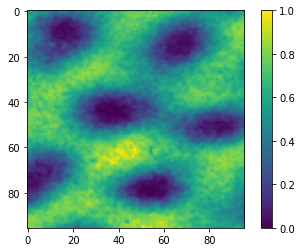

In [3]:
img_arr = plt.imread("mcm41_reduced.png")
normalize(img_arr)
plt.imshow(img_arr)
bar = plt.colorbar()

In [4]:
x0max,x1max =np.shape(img_arr)

def target(_x0,_x1):
    _x0 = (x0max-1.)*_x0
    _x1 = (x1max-1.)*_x1
    i_x0 = _x0.astype(int)
    i_x1 = _x1.astype(int)
    return img_arr[i_x0,i_x1]


In [5]:
grid_size = 48
X = np.meshgrid(np.linspace(0,1,grid_size),np.linspace(0,1,grid_size), indexing='ij')
batch_size = grid_size**2
aₒ = np.zeros([batch_size,2])
aₒ[:,0] = X[0].flatten()
aₒ[:,1] = X[1].flatten()
Ytest = target(aₒ[:,0],aₒ[:,1])

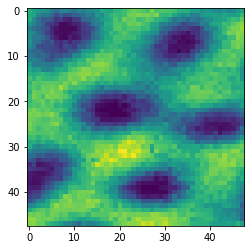

In [6]:
plt.imshow(Ytest.reshape(grid_size,grid_size))

In [7]:
from scipy.special import expit as sigmoid
def ffprime(z):
    '''calculate f(z) and f'(z); sigmoid.'''
    _f = sigmoid(z)
    return _f,_f * (1.0-_f)

def feed_forward(aₒ,w,b):
    '''Propagate an input vector x = aₒ through 
       a network with weights (w) and biases (b).
       Return: activations (a) and derivatives f'(z).'''
    
    a,df = [aₒ],[]
    for wℓ,bℓ in zip(w,b):
        zℓ = np.dot(a[-1],wℓ) + bℓ
        _a,_df = ffprime(zℓ)
        a.append(_a)
        df.append(_df)
        
    return a,df
def backpropagation(y,a,w,b,df): 
    '''Inputs: results of a forward pass
       Targets     y: dim(y)  = batch_size ⨯ nL
       Activations a: dim(a)  = L ⨯ batch_size ⨯ nℓ
       Weights     w: dim(w)  = L-1 ⨯ nℓ₋₁ ⨯ nℓ
       Biases      b: dim(b)  = L-1 ⨯ nℓ
       f'(z)      df: dim(df) = L-1 ⨯ batch_size ⨯ nℓ
       
       Outputs: returns mini-batch averaged gradients of the cost function w.r.t. w and b
       dC_dw: dim(dC_dw) = dim(w)
       dC_db: dim(dC_db) = dim(b)
    '''
    
    num_layers = len(w)
    L = num_layers-1        
    batch_size = len(y)
    
    # initialize empty lists to store the derivatives of the cost functions
    dC_dw = [None]*num_layers
    dC_db = [None]*num_layers
    Δ = [None]*num_layers
    
    # perform the backpropagation
    for ℓ in reversed(range(num_layers)):
        
        # treat the last layer differently
        if ℓ == L:
            Δ[ℓ] = (a[ℓ] - y)*df[ℓ]
        else: 
            Δ[ℓ] = (Δ[ℓ+1] @ w[ℓ+1].T) * df[ℓ]
            
        dC_dw[ℓ] = (a[ℓ-1].T @ Δ[ℓ]) / batch_size
        dC_db[ℓ] = np.average(Δ[ℓ],axis=0)
        
    return dC_dw,dC_db

def gradient_step(η,w,b,dC_dw,dC_db):
    '''Update the weights and biases as per gradient descent.'''
    
    for ℓ in range(len(w)):
        w[ℓ] -= η*dC_dw[ℓ]
        b[ℓ] -= η*dC_db[ℓ]
    return w,b

def train_network(x,y,w,b,η):
    '''Train a deep neural network via feed forward and back propagation.
       Inputs:
       Input         x: dim(x) = batch_size ⨯ n₁
       Target        y: dim(y) = batch_size ⨯ nL
       Weights       w: dim(w)  = L-1 ⨯ nℓ₋₁ ⨯ nℓ
       Biases        b: dim(b)  = L-1 ⨯ nℓ
       Learning rate η
       
       Outputs: the least squared cost between the network output and the targets.
       '''
    
    a,df = feed_forward(x,w,b)
    
    # we pass a cycled a by 1 layer for ease of indexing
    dC_dw,dC_db = backpropagation(y,a[1:]+[a[0]],w,b,df)
    
    w,b = gradient_step(η,w,b,dC_dw,dC_db)
    
    return 0.5*np.average((y-a[-1])**2)
def make_batch(n,batch_size,extent,func):
    '''Create a mini-batch from our inputs and outputs.
    Inputs:
    n0        : number of neurons in each layer
    batch_size: the desired number of samples in the mini-batch
    extent    : [min(xₒ),max(xₒ), min(x₁),max(x₁),…,min(x_{n[0]-1}),max(x_{n[0]-1})]
    func:     : the desired target function.
    
    Outputs: returns the desired mini-batch of inputs and targets.
    '''
    
    x = np.zeros([batch_size,n[0]])
    for i in range(n[0]):
        x[:,i] = np.random.uniform(low=0.0,high=1.0,size=[batch_size])
    
    
    y = func(*[x[:,j] for j in range(n[0])]).reshape(-1,n[-1])
    
    return x,y 
def feed_forward_simple(aₒ,w,b):
    '''Propagate an input vector x = aₒ through 
       a network with weights (w) and biases (b). '''
    a = aₒ
    for wℓ,bℓ in zip(w,b):
        z = np.dot(a,wℓ) + bℓ
        
        # using a sigmoid for non-linearity
        a = 1.0/(1.0+np.exp(-z))
    return a

In [56]:
extent = [0., 1.0, 0., 1.0]
n = [2,203,100,1]
w,b = [],[]
for ℓ in range(len(n)-1):
    w.append(np.random.uniform(low=-5,high=5, size=(n[ℓ],n[ℓ+1])))
    b.append(np.random.uniform(low=-1,high=1, size=n[ℓ+1]))
    

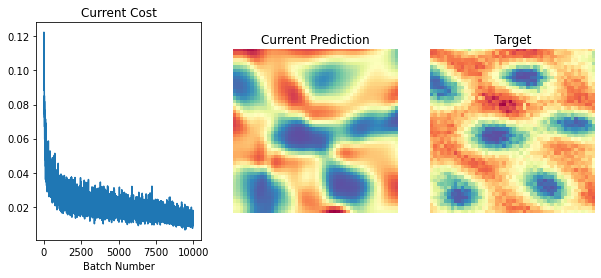

In [57]:
from IPython.display import clear_output,display

η = 0.9

batch_size = 400
num_steps = 10000
plot_ratio = int(num_steps / 50)

w_best, b_best = [],[]
cost_best = 10000.

costs = np.zeros(num_steps)
for j in range(num_steps):
    
    x,y = make_batch(n,batch_size,extent,target)

    costs[j] = train_network(x,y,w,b,η)
    if (costs[j]<cost_best):
        cost_best=costs[j]
        w_best = np.array(w,copy=True)
        b_best = np.array(b,copy=True)
    # we plot every plot_ratio steps
    if not j % plot_ratio or j == num_steps-1:
        
        clear_output(wait=True)
        ret = feed_forward(aₒ,w,b)
        aL = ret[0][-1].reshape(grid_size,grid_size)#feed_forward_simple(aₒ,w,b).reshape(grid_size,grid_size)
        fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(10,4))
        
        ax[1].axis('off')
        img = ax[1].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
               interpolation='nearest', origin='lower', aspect='equal')
        
        ax[2].axis('off')
        ax[2].imshow(Ytest.reshape(grid_size,grid_size), cmap='Spectral_r', rasterized=True, 
           interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

        ax[0].plot(costs)

        ax[0].set_title("Current Cost")
        ax[0].set_xlabel("Batch Number")
        ax[1].set_title("Current Prediction")
        ax[2].set_title("Target")

        plt.show()
        
        # uncoment if plotting is too fast
        #sleep(0.1)

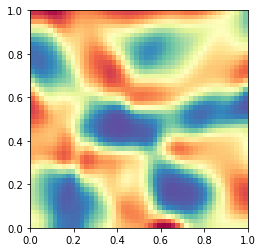

In [58]:
ret = feed_forward(aₒ,w_best,b_best)
aL = ret[0][-1].reshape(grid_size,grid_size)
plt.imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
               interpolation='nearest', origin='lower', aspect='equal')

In [59]:
import json
data = {"Topology":n,"batch size":batch_size,"num_steaps":num_steps,"eta":float(η)}
with open("A03_3.json","w") as outfile:
    json.dump(data,outfile,indent=1)

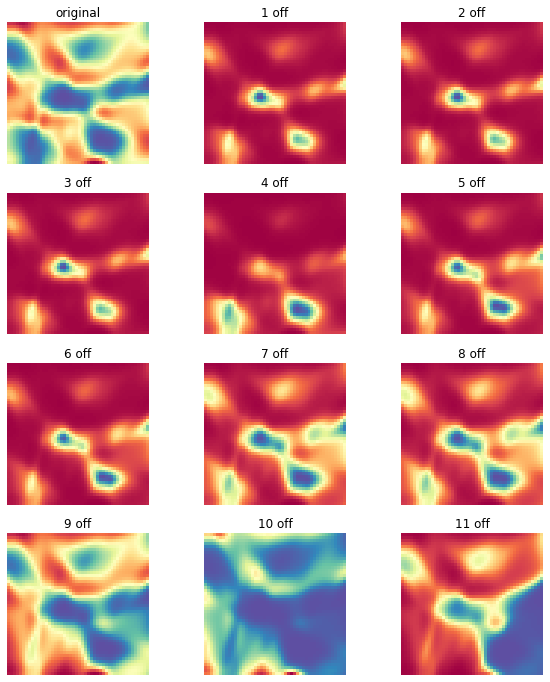

In [60]:
fig,ax = plt.subplots(ncols=3,nrows=4,figsize=(10,12))
    
    
w_x = w_best
b_x = b_best
w_arr = w_x[2]

ret = feed_forward(aₒ,w_x,b_x)
aL = ret[0][-1].reshape(grid_size,grid_size)
ax[0,0].axis('off')
ax[0,0].set_title('original')
ax[0,0].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal')

for i in range(11):
    ax[int((i+1)/3),int((i+1)%3)].axis('off')
    w_arr[i,0] = 0.0
    w_x[2]=w_arr
    ret = feed_forward(aₒ,w_x,b_x)
    aL = ret[0][-1].reshape(grid_size,grid_size)
    
    ax[int((i+1)/3),int((i+1)%3)].set_title(str(i+1) + ' off')
    ax[int((i+1)/3),int((i+1)%3)].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal')

    
plt.show()

This was oddly stable as I turned off neurons. I had tried running to this point a few times and as I turned off neurons and generally there was a loss of detail as I did so. Here, it looks like Neurons 0:8 are almost canceling each other out.